In [1]:
import pandas as pd
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim import corpora, models
import gensim
import numpy as np
from gensim.models import CoherenceModel
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import operator
from sklearn.decomposition import NMF
from collections import defaultdict
import shutil
import os

path_to_allrecipes = 'archive/allrecipes-recipes.json.xz'
path_to_kaggle = 'archive/Food Ingredients and Recipe Dataset with Image Name Mapping.csv'
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shru\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Clean DataSet

In [2]:
def combine_datasets(path_to_kaggle, path_to_allrecipes):
    def read_file(path):
        recipes_lines = [json.loads(line) for line in open(path, 'r')]
        return pd.DataFrame(recipes_lines)

    df_all_recipies = pd.read_json(path_to_allrecipes,lines=True, compression='xz')
    df_all_recipies = df_all_recipies[df_all_recipies['photo_url'] != "http://images.media-allrecipes.com/global/recipes/nophoto/nopicture-910x511.png"]
    df_all_recipies = df_all_recipies[["ingredients", "instructions", "photo_url", "title"]]
    
    df_kaggle = pd.read_csv(path_to_kaggle)
    df_kaggle['Instructions'] = df_kaggle.apply(lambda x: [x.Instructions], axis=1)
    df_kaggle.rename(columns={"Title":"title", "Cleaned_Ingredients":"ingredients", "Instructions": "instructions", "Image_Name":"photo_url"}, inplace = True)
    df_kaggle = df_kaggle[["ingredients", "instructions", "photo_url", "title"]]
    final_df = pd.concat([df_all_recipies, df_kaggle])
    
    return final_df

def clean_dataset(dataset):
    def remove_values(x):
        prohibitedWords = [' and ', ' with ', ' the ', 'easy', 'best', ' i ', 'ii', 'iii', 'iv']
        big_regex = re.compile('|'.join(map(re.escape, prohibitedWords)))
        l = [big_regex.sub(" ", str(t).lower()) for t in x]
        return l
    data = dataset.assign(recipe_name = lambda x: remove_values(x['title']))
    return data

def tokenize_words(data):
    de_stop = stopwords.words('english')
    tokenizer = RegexpTokenizer(r'\w+')
    final_names=[]
    recipe_name = data['recipe_name'].tolist()
    for rec in recipe_name:
        raw = rec.lower()
        tokens = tokenizer.tokenize(raw)
        stop_t = [recipe_name for recipe_name in tokens if not recipe_name in de_stop]
        stem_t = [i for i in stop_t if len(i)>1]
        if len(stem_t)==0: final_names.append(['error'])
        else: final_names.append(stem_t)
    return (recipe_name, final_names)


In [3]:
data = clean_dataset(combine_datasets(path_to_kaggle, path_to_allrecipes))
recipe_name, final_names = tokenize_words(data)

### Train LDA 

In [4]:
def build_dict_and_corpus(final_names):
    dictionary = corpora.Dictionary(final_names)
    corpus = [dictionary.doc2bow(text) for text in final_names]
    return (dictionary, corpus)

In [5]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

def train_lda(corpus, dictionary):
    num_topics = list(range(50,150,10))
    num_keywords = 15

    LDA_models = {}
    LDA_topics = {}
    for i in num_topics:
        print(i)
        LDA_models[i] = gensim.models.ldamodel.LdaModel(corpus, num_topics=i,passes=1, chunksize=len(corpus), random_state=0, id2word=dictionary)
        shown_topics = LDA_models[i].show_topics(num_topics=i, num_words=num_keywords, formatted=False)
        LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
    coherences = [CoherenceModel(model=LDA_models[i], texts=final_names, dictionary=dictionary, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]
    print("Coherences:", coherences)

    LDA_stability = {}
    for i in range(0, len(num_topics)-1):
        jaccard_sims = []
        for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
            sims = []
            for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
                sims.append(jaccard_similarity(topic1, topic2))    

            jaccard_sims.append(sims)    

        LDA_stability[num_topics[i]] = jaccard_sims

    mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]
    print("Mean Stabilities:", mean_stabilities)
    coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(len(num_topics[:-1]))] # limit topic numbers to the number of keywords
    coh_sta_max = max(coh_sta_diffs)
    coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
    ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
    ideal_topic_num = num_topics[ideal_topic_num_index]
    plt.figure(figsize=(20,10))
    ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
    ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

    ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
    ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

    y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
    ax.set_ylim([0, y_max])
    ax.set_xlim([1, num_topics[-1]-1])

    ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
    ax.set_ylabel('Metric Level', fontsize=20)
    ax.set_xlabel('Number of Topics', fontsize=20)
    plt.legend(fontsize=20)
    plt.show()   


50
60
70
80
90
100
110
120
130
140
Coherences: [0.2881875189693908, 0.27034217457012005, 0.2559300195894485, 0.287925915176533, 0.310625846108634, 0.34916380715752604, 0.318758752426189, 0.3658859692552004, 0.4209314126506291]
Mean Stabilities: [0.23028356427173458, 0.22478467243124764, 0.18433657978834198, 0.1517778391560064, 0.13130017980664208, 0.08986758290620331, 0.04245215212368896, 0.20285037477964288, 0.4655293860826805]


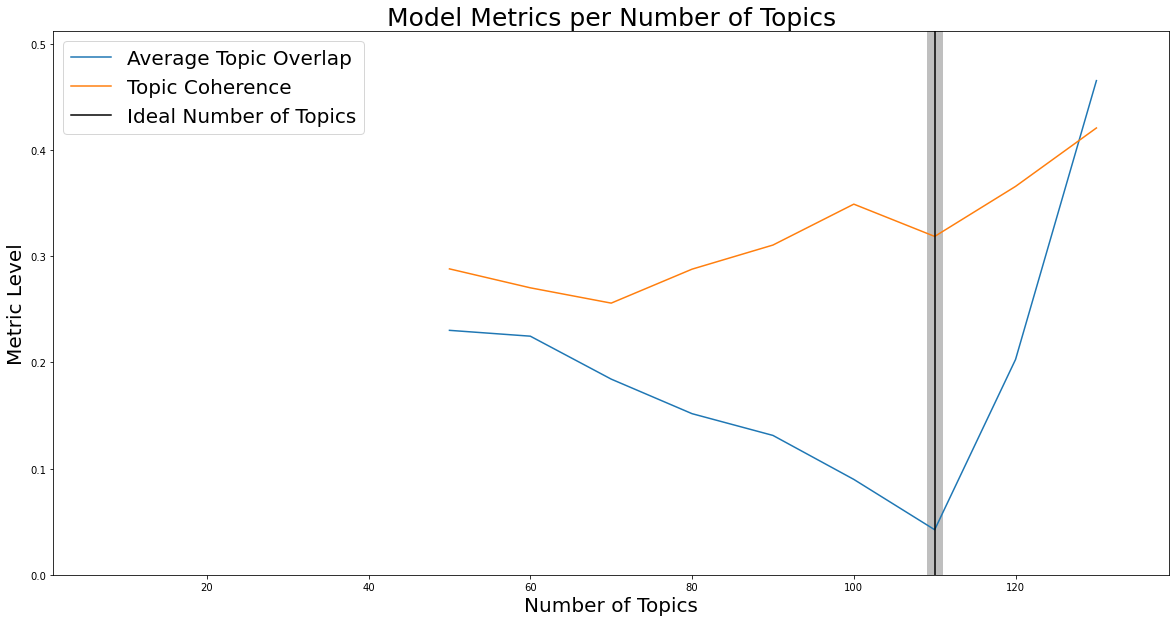

In [6]:
dictionary, corpus = build_dict_and_corpus(final_names)
train_lda(corpus, dictionary)

### Main LDA

In [9]:
def lda_model(corpus, num_of_topics, dictionary):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_of_topics, passes=1, chunksize=len(corpus), random_state=0, id2word=dictionary)
    return ldamodel

In [10]:
ldamodel = lda_model(corpus, 110, dictionary)
ldamodel.print_topics(num_topics=110,num_words = 15)

[(0,
  '0.022*"three" + 0.022*"pizza" + 0.022*"sausage" + 0.022*"skillet" + 0.022*"cheese" + 0.022*"style" + 0.022*"johnsonville" + 0.022*"chicken" + 0.022*"italian" + 0.011*"salad" + 0.011*"quinoa" + 0.011*"con" + 0.006*"sweet" + 0.006*"quesadillas" + 0.006*"shoot"'),
 (1,
  '0.013*"chicken" + 0.007*"pepper" + 0.007*"mole" + 0.007*"red" + 0.007*"fingerling" + 0.007*"parsley" + 0.007*"jerk" + 0.007*"cakes" + 0.007*"garlic" + 0.007*"jus" + 0.007*"ice" + 0.007*"eyed" + 0.007*"broccoli" + 0.007*"skillet" + 0.007*"anglaise"'),
 (2,
  '0.007*"halibut" + 0.007*"coconut" + 0.007*"italian" + 0.007*"braised" + 0.007*"cheese" + 0.007*"sausage" + 0.007*"three" + 0.007*"skillet" + 0.007*"lemongrass" + 0.007*"chutney" + 0.007*"ginger" + 0.007*"eggplant" + 0.007*"fillets" + 0.007*"pizza" + 0.007*"style"'),
 (3,
  '0.019*"potato" + 0.012*"bacon" + 0.012*"sausage" + 0.012*"skillet" + 0.012*"italian" + 0.006*"crumbs" + 0.006*"pizza" + 0.006*"pancakes" + 0.006*"medley" + 0.006*"tomatoes" + 0.006*"bisque

### TFIDF

In [4]:
def tfidf_model(final_names):
    data_samples = [' '.join(ti) for ti in final_names]
    tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=None)
    tfidf = tfidf_vectorizer.fit_transform(data_samples)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    return (tfidf, tfidf_feature_names)

In [5]:
def rank_terms(A, terms):
    sums = A.sum(axis=0)
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

def visualize_topics(ranking):
    topic_n = []
    for i, pair in enumerate(ranking[0:10]):
        topic_n.append(pair[0])
        print( "%02d. %s (%.2f)" % (i+1, pair[0], pair[1]))

In [6]:
tfidf, tfidf_feature_names = tfidf_model(final_names)
ranking = rank_terms(tfidf, tfidf_feature_names)
topic_n = visualize_topics(ranking)

01. chicken (2272.10)
02. salad (1798.09)
03. chocolate (1270.53)
04. cake (1231.05)
05. pie (1133.84)
06. soup (1127.89)
07. cheese (1058.56)
08. sauce (1028.70)
09. cookies (1024.20)
10. bread (901.91)


### NMF

In [11]:
def nmf(num_comp, tfidf):
    nmf = NMF(n_components=num_comp, random_state=1, verbose=1, max_iter=200).fit(tfidf)
    nmf_emb = nmf.transform(tfidf)
    top_idx = np.argsort(nmf_emb,axis=0)[-1:]
    show_ten = num_comp+1
    count_idxs = 0
    final_topics = []
    for idxs in top_idx.T:
        if count_idxs == show_ten: break
        for idx in idxs:
            final_topics.append(final_names[idx])
        count_idxs += 1
    return (nmf, nmf_emb, final_topics)

In [12]:
def print_top_words(model, feature_names, n_top_words):
    manual_topic_cat = []
    for topic_idx, topic in enumerate(model.components_[:50]): # just show first 10 topics
        print("Topic #%d:" % topic_idx)
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            manual_topic_cat.append(feature_names[i])
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    return manual_topic_cat

def get_top_recipes_for_category(recipes_all_list, w_vector, recipe_index, top):
    top_indic = np.argsort(w_vector[:,recipe_index])[::-1] # umdrehen
    top_result = [] # return result as list
    for rec_index in top_indic[0:top]:
        top_result.append(recipes_all_list[rec_index])
    return top_result

def get_top_cat_for_recipe(recipes_all_list, w_vector, final_topics):
    final_recipes_cat_name = []
    recipe_cat_link = []
    for r in range(len(recipes_all_list)):
        one_hot_matrix = w_vector[r,:]
        all_zeros = not one_hot_matrix.any() # no fitting category
        if all_zeros: 
            recipe_cat_link.append(-1) # no fitting category
        else:
            top_indic = np.argsort(one_hot_matrix)[::-1][0] # 1. umdrehen 2. return erste
            recipe_cat_link.append(top_indic)
    for num in recipe_cat_link:
        if num == -1: 
            final_recipes_cat_name.append('no_cat')
        else: 
            final_recipes_cat_name.append(final_topics[num])
    return final_recipes_cat_name

In [13]:
nmf, nmf_emb, final_topics = nmf(50, tfidf)
print_top_words(nmf, tfidf_feature_names, 10)
top_result = get_top_recipes_for_category(recipe_name, nmf_emb, 1, 10)
print(top_result)
categories_for_recipes = get_top_cat_for_recipe(recipe_name, nmf_emb, final_topics)

C:\Users\Shru\anaconda3\envs\cs7643-a4\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


violation: 1.0
violation: 0.2155689762227214
violation: 0.10908997888529301
violation: 0.06910238414897138
violation: 0.044263619457772636
violation: 0.0292798200530504
violation: 0.022590922739200894
violation: 0.018530313455421582
violation: 0.0161409092968958
violation: 0.013599791828444374
violation: 0.01131850640482199
violation: 0.009432006069528652
violation: 0.008282131100097295
violation: 0.007611003315890785
violation: 0.006994055013590916
violation: 0.006297264222245237
violation: 0.005614696384997175
violation: 0.005102165375110644
violation: 0.004581471538779771
violation: 0.004116063422080472
violation: 0.003675494420306746
violation: 0.003237463009717813
violation: 0.0028843250952322653
violation: 0.0026637584020613235
violation: 0.0024798466809158753
violation: 0.0023415959836157532
violation: 0.002246965419063107
violation: 0.002185134362516504
violation: 0.002113775724112471
violation: 0.002056660984216301
violation: 0.0020135514450478195
violation: 0.0019854123278774

In [14]:
categories_for_recipes 

[['roasted', 'chicken'],
 ['cheese', 'baked', 'macaroni', 'cheese'],
 ['bread'],
 ['bread'],
 ['cranberry', 'orange', 'cookies'],
 ['banana', 'banana', 'bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['stuffed', 'chicken'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['pumpkin', 'cake'],
 ['bread'],
 ['banana', 'banana', 'bread'],
 ['bread'],
 ['bread'],
 ['banana', 'banana', 'bread'],
 ['bread'],
 ['bread'],
 ['tomato', 'chicken'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['muffins'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['muffins'],
 ['bread'],
 ['bread'],
 ['chocolate', 'chocolate', 'chip', 'cookies'],
 ['banana', 'banana', 'bread'],
 ['banana', 'banana', 'bread'],
 ['banana', 'banana', 'bread'],
 ['bacon'],
 ['bread'],
 ['garlic', 'steak', 'garlic'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['bread'],
 ['stra

### Categorize Images

In [15]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

def movePic(src, dest):
    shutil.copy(src, dest)
    
def categorize_folders(data, categories_for_recipes):
    data['category'] = categories_for_recipes
    directories_names = []

    for directt in categories_for_recipes:
        d_name = '_'.join(directt)
        directories_names.append(d_name)

    for curr_dir_category in directories_names:
        createFolder('archive/input/images/images/' + curr_dir_category)
    data['directories_names'] = directories_names
    return data

def classify_images(data):
    image_category = defaultdict(list)
    for index, row in data.iterrows():
        image_category[row.directories_names].append(row.photo_url)
        
    for directory in image_category.keys():
        print(directory+':')
        for image in image_category[directory]:
            if "http://images.media-allrecipes.com/" in image:
                image_dir = image.split(".com")[1]
                image_name = image_dir.split('/')[-1]
                try:
                    movePic(r"C:/Users/Shru/Desktop/Georgia Tech Master/Summer 2022/project/archive"+image_dir, r"C:/Users/Shru/Desktop/Georgia Tech Master/Summer 2022/project/archive/input/images/images/"+directory+'/'+image_name)
                except:
                    print(image_dir)
            else:
                try:
                    movePic(r"C:/Users/Shru/Desktop/Georgia Tech Master/Summer 2022/project/archive/dataset/"+image+'.jpg', r"C:/Users/Shru/Desktop/Georgia Tech Master/Summer 2022/project/archive/input/images/images/"+directory+'/'+image+'.jpg')
                except:
                    print(image)

In [16]:
data = categorize_folders(data, categories_for_recipes)
classify_images(data)

roasted_chicken:
#NAME?
cheese_baked_macaroni_cheese:
bread:
/userphotos/560x315/1122530.jpg
/userphotos/560x315/1168027.jpg
/userphotos/560x315/1117377.jpg
/userphotos/560x315/1114935.jpg
cranberry_orange_cookies:
banana_banana_bread:
/userphotos/560x315/2279903.jpg
/userphotos/560x315/1123345.jpg
stuffed_chicken:
/userphotos/560x315/1122101.jpg
#NAME?
#NAME?
pumpkin_cake:
/userphotos/250x250/979703.jpg
/userphotos/560x315/1096676.jpg
#NAME?
#NAME?
tomato_chicken:
/userphotos/250x250/979815.jpg
#NAME?
muffins:
/userphotos/560x315/1118491.jpg
/userphotos/560x315/1121576.jpg
chocolate_chocolate_chip_cookies:
/userphotos/560x315/1116488.jpg
/userphotos/560x315/1123977.jpg
/userphotos/560x315/1121100.jpg
/userphotos/250x250/979740.jpg
/userphotos/560x315/1114479.jpg
bacon:
/userphotos/560x315/1122561.jpg
/userphotos/560x315/1119728.jpg
/userphotos/560x315/1117012.jpg
#NAME?
garlic_steak_garlic:
/userphotos/560x315/1122222.jpg
/userphotos/560x315/1121479.jpg
strawberry_chicken:
/userphotos